### A/334 Parameter Specification
- Autocorrection Delay = 3ms
- Sysmbol interval T = 1/106 seconds
- Marking Frequency Band = 2.5kHz - 5.0kHz

### Sample 
- frequency 48kHz -> 48000 frames/second
- Symbol frames 48000/106 = ca. 453 frames

### Help


In [9]:
import time
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from scipy.signal import butter, lfilter
from pydub import AudioSegment
import pandas as pd

In [10]:
audioSegment = AudioSegment.from_file("video.ts")
sig = np.frombuffer(audioSegment.raw_data, dtype='<i4').reshape(-1, audioSegment.channels)
samplerate = audioSegment.frame_rate

In [11]:
offset_sec = 0.003
offset_frames = round(samplerate * offset_sec)
symbols_per_sec = 106
samples_per_symbol = samplerate / symbols_per_sec
samples_per_symbol

452.8301886792453

In [12]:
#https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [13]:
sig_bandpassed = butter_bandpass_filter(sig[:, 0], 2500, 5000, samplerate)

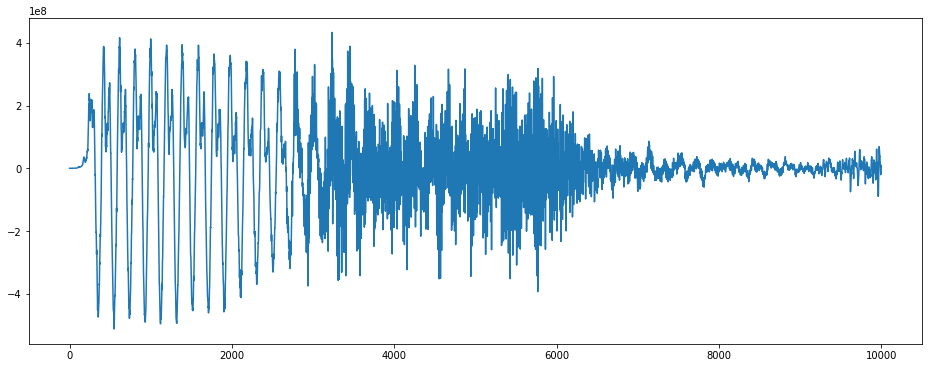

In [14]:
plt.figure(figsize=(16, 6))
plt.plot(sig[:10000, 0])

should be 22.083333333333332 symbols
Time to run: 4.94 seconds


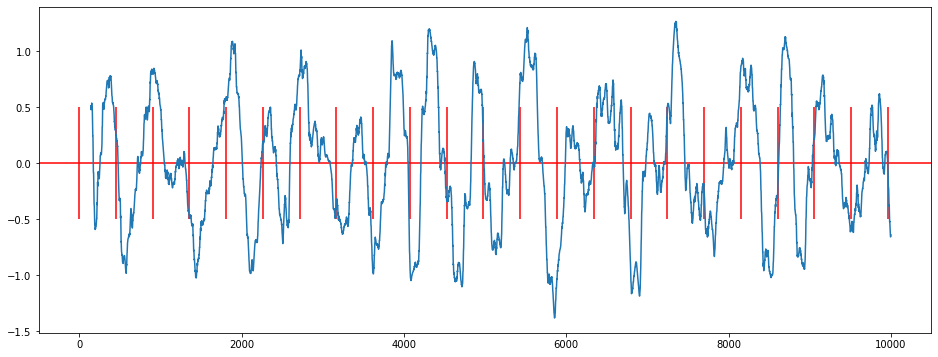

In [15]:
start_time = time.time()
samples = 10000
print(f"should be {symbols_per_sec * samples / samplerate} symbols")
sigg = sig_bandpassed

half_symbol = int(samples_per_symbol / 2)

df_first = pd.DataFrame(sigg[:-offset_frames - half_symbol])
df_first_2 = pd.DataFrame(sigg[half_symbol:-offset_frames])
df_delayed = pd.DataFrame(sigg[offset_frames: - half_symbol])
df_delayed_2 = pd.DataFrame(sigg[offset_frames + half_symbol:])

a = df_first.rolling(offset_frames).corr(df_delayed)
b = df_first_2.rolling(offset_frames).corr(df_delayed_2)

diffs = (a-b)[:samples].to_numpy()

plt.figure(figsize=(16, 6))
plt.vlines(np.arange(0, samples, samples_per_symbol), -0.5, 0.5, colors=["red"])
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(diffs, '-')
print(f"Time to run: {(time.time() - start_time):.2f} seconds")

In [16]:
MESSAGE_HEADER = '10101110000010101011100111100100'
for i in range(samples - 5000):
    is_correct = True
    for j in range(len(MESSAGE_HEADER)):
        if not (diffs[int(j * samples_per_symbol + i)] >= 0 and MESSAGE_HEADER[j] == '1' or diffs[
            int(j * samples_per_symbol + i)] < 0 and MESSAGE_HEADER[j] == '0'):
            is_correct = False
            break
    if is_correct:
        print(f"found offset for message start {i}")